<a href="https://colab.research.google.com/github/LilySu/DS-Unit-2-Regression-2/blob/master/DS_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [267]:
!pip install eli5

In [268]:
!pip install pdpbox

In [0]:
import pandas as pd
import numpy as np
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

In [270]:
train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1


In [271]:
test.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,10,5,2015-07-31,7185,681,1,1
1,15,5,2015-07-31,9191,766,1,1


In [272]:
store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN


In [273]:
set(train.columns) & set(store.columns)#are there shared columns, print file name 


{'Store'}

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [274]:
train_store = pd.merge(train, store, on = ['Store'], how='outer')
train_store.drop_duplicates(['Store'],inplace=True)
train_store.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,5.0,2015-07-31,13995.0,1498.0,1.0,1.0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
784,8,5.0,2015-07-31,8492.0,833.0,1.0,1.0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN


In [275]:
test_store = pd.merge(test, store, on = ['Store'], how='outer')
test_store.drop_duplicates(['Store'],inplace=True)
test_store.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,10,5.0,2015-07-31,7185.0,681.0,1.0,1.0,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
784,15,5.0,2015-07-31,9191.0,766.0,1.0,1.0,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [288]:
from datetime import datetime, timedelta

train_store['Date'] = pd.to_datetime(train_store['Date'], format='%Y-%m-%d')
test_store['Date'] = pd.to_datetime(test_store['Date'], format='%Y-%m-%d')
train_store['Year'] = train_store['Date'].dt.year
test_store['Year'] = test_store['Date'].dt.year
train_store['Month'] = train_store['Date'].dt.month
test_store['Month'] = test_store['Date'].dt.month
train_store['Day'] = train_store['Date'].dt.day
test_store['Day'] = test_store['Date'].dt.day

train_store = train_store.drop(columns = ['Date', 'SchoolHoliday', 'Promo'])
test_store = test_store.drop(columns = ['Date', 'SchoolHoliday', 'Promo'])


train_store.head(2)

,Store,DayOfWeek,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,4,5.0,13995.0,1498.0,c,c,620.0,9.0,2009.0,0,53.0,2009.0,NaN,2015,7,31
784,8,5.0,8492.0,833.0,a,a,7520.0,10.0,2014.0,0,53.0,2009.0,NaN,2015,7,31


In [289]:
train_store['Promo2SinceWeek'].value_counts()

53.0    80
35.0     4
40.0     3
22.0     3
18.0     2
14.0     2
1.0      2
31.0     1
48.0     1
5.0      1
13.0     1
Name: Promo2SinceWeek, dtype: int64

In [290]:
train_store['SchoolHoliday'].value_counts()

KeyError: ignored

In [291]:
train_store['Promo2SinceYear'].value_counts()

2009.0    80
2012.0    10
2010.0     4
2013.0     3
2011.0     3
Name: Promo2SinceYear, dtype: int64

In [0]:
train_store[['Promo2SinceWeek']] = train_store[['Promo2SinceWeek']].fillna(value = 53)
test_store[['Promo2SinceWeek']] = test_store[['Promo2SinceWeek']].fillna(value = 53)
train_store[['Promo2SinceYear']] = train_store[['Promo2SinceYear']].fillna(value = 2009)
test_store[['Promo2SinceYear']] = test_store[['Promo2SinceYear']].fillna(value = 2009)

In [293]:
null_test = test_store[test_store['Sales'].isnull() == True]
null_train = train_store[train_store['Sales'].isnull() == True]
train_store = train_store[train_store['Sales'].isnull() == False]
test_store = test_store[test_store['Sales'].isnull() == False]

null_train.shape, train_store.shape, null_test.shape, test_store.shape

((0, 16), (100, 16), (0, 16), (100, 16))

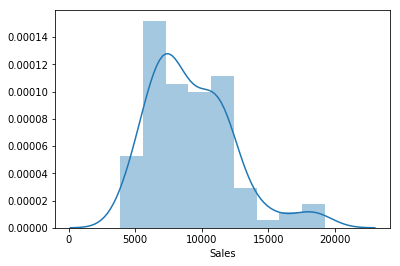

In [294]:
from sklearn.model_selection import train_test_split
import seaborn as sns

target = 'Sales'
y = train_store[target]
X = train_store.drop(columns=['Sales'])

sns.distplot(y);

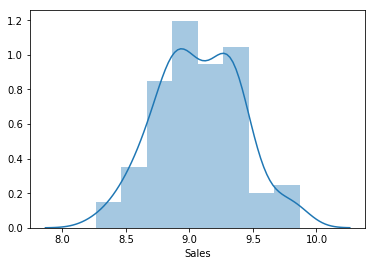

In [295]:
y_log = np.log1p(y)

import numpy as np
sns.distplot(y_log);

In [296]:
X_train, X_val, y_train, y_val = train_test_split(X,y_log,train_size=.60,test_size=.40,random_state=42)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

X_test = test_store.drop(columns=['Sales'])
y_test = test_store['Sales']
X_train.shape, X_val.shape, X_test.shape

((60, 15), (40, 15), (100, 15))

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [297]:
import category_encoders as ce
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[17:42:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.63368	validation_1-rmse:1.62892
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.47307	validation_1-rmse:1.4683
[2]	validation_0-rmse:1.32827	validation_1-rmse:1.32348
[3]	validation_0-rmse:1.19772	validation_1-rmse:1.19291
[4]	validation_0-rmse:1.08002	validation_1-rmse:1.07519
[5]	validation_0-rmse:0.973913	validation_1-rmse:0.969054
[6]	validation_0-rmse:0.878255	validation_1-rmse:0.873367
[7]	validation_0-rmse:0.792021	validation_1-rmse:0.787101
[8]	validation_0-rmse:0.714286	validation_1-rmse:0.709331
[9]	validation_0-rmse:0.644215	validation_1-rmse:0.639221
[10]	validation_0-rmse:0.581056	validation_1-rmse:0.576019
[11]	validation_0-rmse:0.524133	validation_1-rmse:0.519047
[12]	validation_0-rmse:0.47

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_train_log.fillna(0,inplace=True)
y_val_log.fillna(0,inplace=True)

X_test.fillna(0,inplace=True)
y_test.fillna(0,inplace=True)
X_train.fillna(0,inplace=True)
X_val.fillna(0,inplace=True)
X_val_encoded.fillna(0,inplace=True)
X_train_encoded.fillna(0,inplace=True)

In [303]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_features': uniform(),
    'randomforestregressor__min_samples_leaf': [1, 10, 100]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train_log)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    criterion='mse',
                                    

In [304]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.8980898169604131, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 241}
Cross-validation RMSLE 0.016446233168759563


In [305]:
results_df = pd.DataFrame(search.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.185970,0.001153,0.020510,0.000101,0.89809,1,241,{'randomforestregressor__max_features': 0.8980...,-0.000337,-0.000204,-0.000270,0.000066,1,-0.000033,-0.000036,-0.000034,1.585700e-06
1,0.092028,0.000272,0.012537,0.000092,0.494158,1,113,{'randomforestregressor__max_features': 0.4941...,-0.000449,-0.000304,-0.000377,0.000073,2,-0.000056,-0.000061,-0.000058,2.442420e-06
2,0.274427,0.000772,0.028016,0.000335,0.377274,10,415,{'randomforestregressor__max_features': 0.3772...,-0.001152,-0.000985,-0.001069,0.000083,4,-0.000933,-0.001139,-0.001036,1.032155e-04
3,0.202213,0.000671,0.023823,0.001366,0.0318258,1,296,{'randomforestregressor__max_features': 0.0318...,-0.000788,-0.000577,-0.000683,0.000106,3,-0.000109,-0.000108,-0.000109,5.976898e-07
4,0.215766,0.003985,0.027961,0.000362,0.133837,100,179,{'randomforestregressor__max_features': 0.1338...,-0.001388,-0.001207,-0.001298,0.000090,5,-0.001192,-0.001371,-0.001281,8.946779e-05


In [306]:
results_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.185970,0.001153,0.020510,0.000101,0.89809,1,241,{'randomforestregressor__max_features': 0.8980...,-0.000337,-0.000204,-0.000270,0.000066,1,-0.000033,-0.000036,-0.000034,1.585700e-06
1,0.092028,0.000272,0.012537,0.000092,0.494158,1,113,{'randomforestregressor__max_features': 0.4941...,-0.000449,-0.000304,-0.000377,0.000073,2,-0.000056,-0.000061,-0.000058,2.442420e-06
3,0.202213,0.000671,0.023823,0.001366,0.0318258,1,296,{'randomforestregressor__max_features': 0.0318...,-0.000788,-0.000577,-0.000683,0.000106,3,-0.000109,-0.000108,-0.000109,5.976898e-07
2,0.274427,0.000772,0.028016,0.000335,0.377274,10,415,{'randomforestregressor__max_features': 0.3772...,-0.001152,-0.000985,-0.001069,0.000083,4,-0.000933,-0.001139,-0.001036,1.032155e-04
4,0.215766,0.003985,0.027961,0.000362,0.133837,100,179,{'randomforestregressor__max_features': 0.1338...,-0.001388,-0.001207,-0.001298,0.000090,5,-0.001192,-0.001371,-0.001281,8.946779e-05


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [262]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0014 ± 0.0001,Customers
0.0000 ± 0.0000,Assortment
0.0000 ± 0.0000,Store
0.0000 ± 0.0000,StoreType
0.0000 ± 0.0000,Promo2SinceWeek
0 ± 0.0000,Day
0 ± 0.0000,Month
0 ± 0.0000,Year
0 ± 0.0000,PromoInterval
0 ± 0.0000,Promo2SinceYear


In [263]:
mask = permuter.feature_importances_ > 0.0#select columns where feature_importances_ is greater than 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_val = X_val[features]

Shape after removing features: (60, 5)


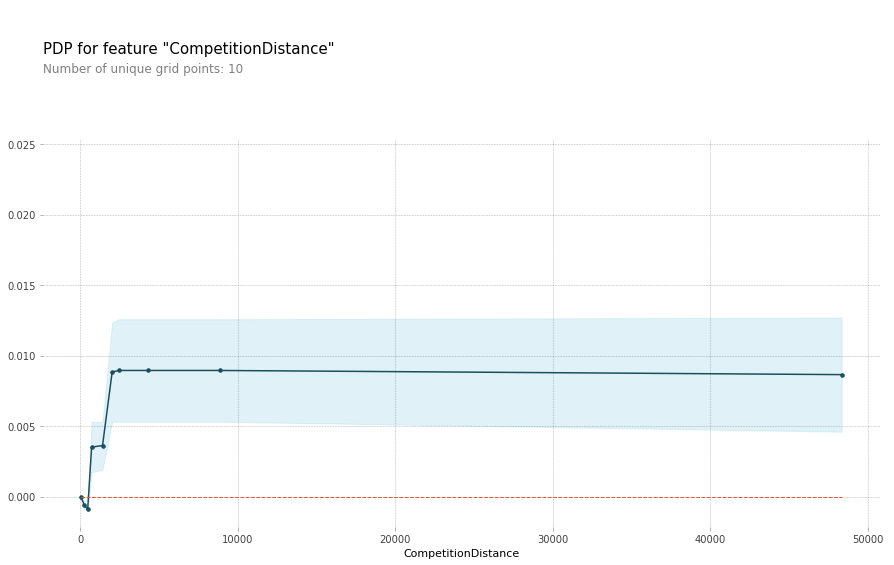

In [266]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'CompetitionDistance'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

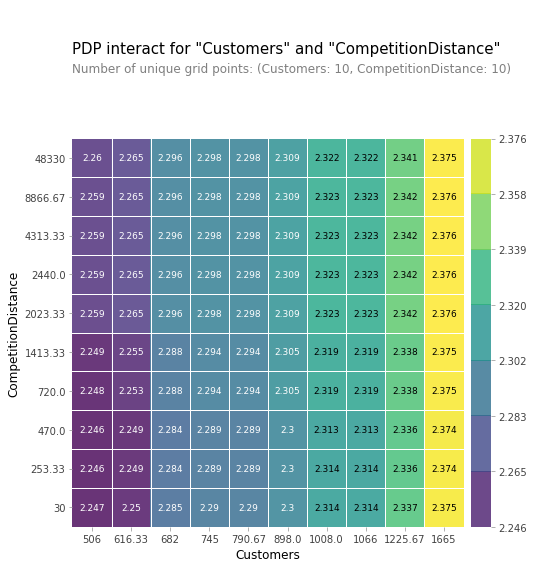

In [265]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Customers', 'CompetitionDistance']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);